error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/arithm.cpp:661: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


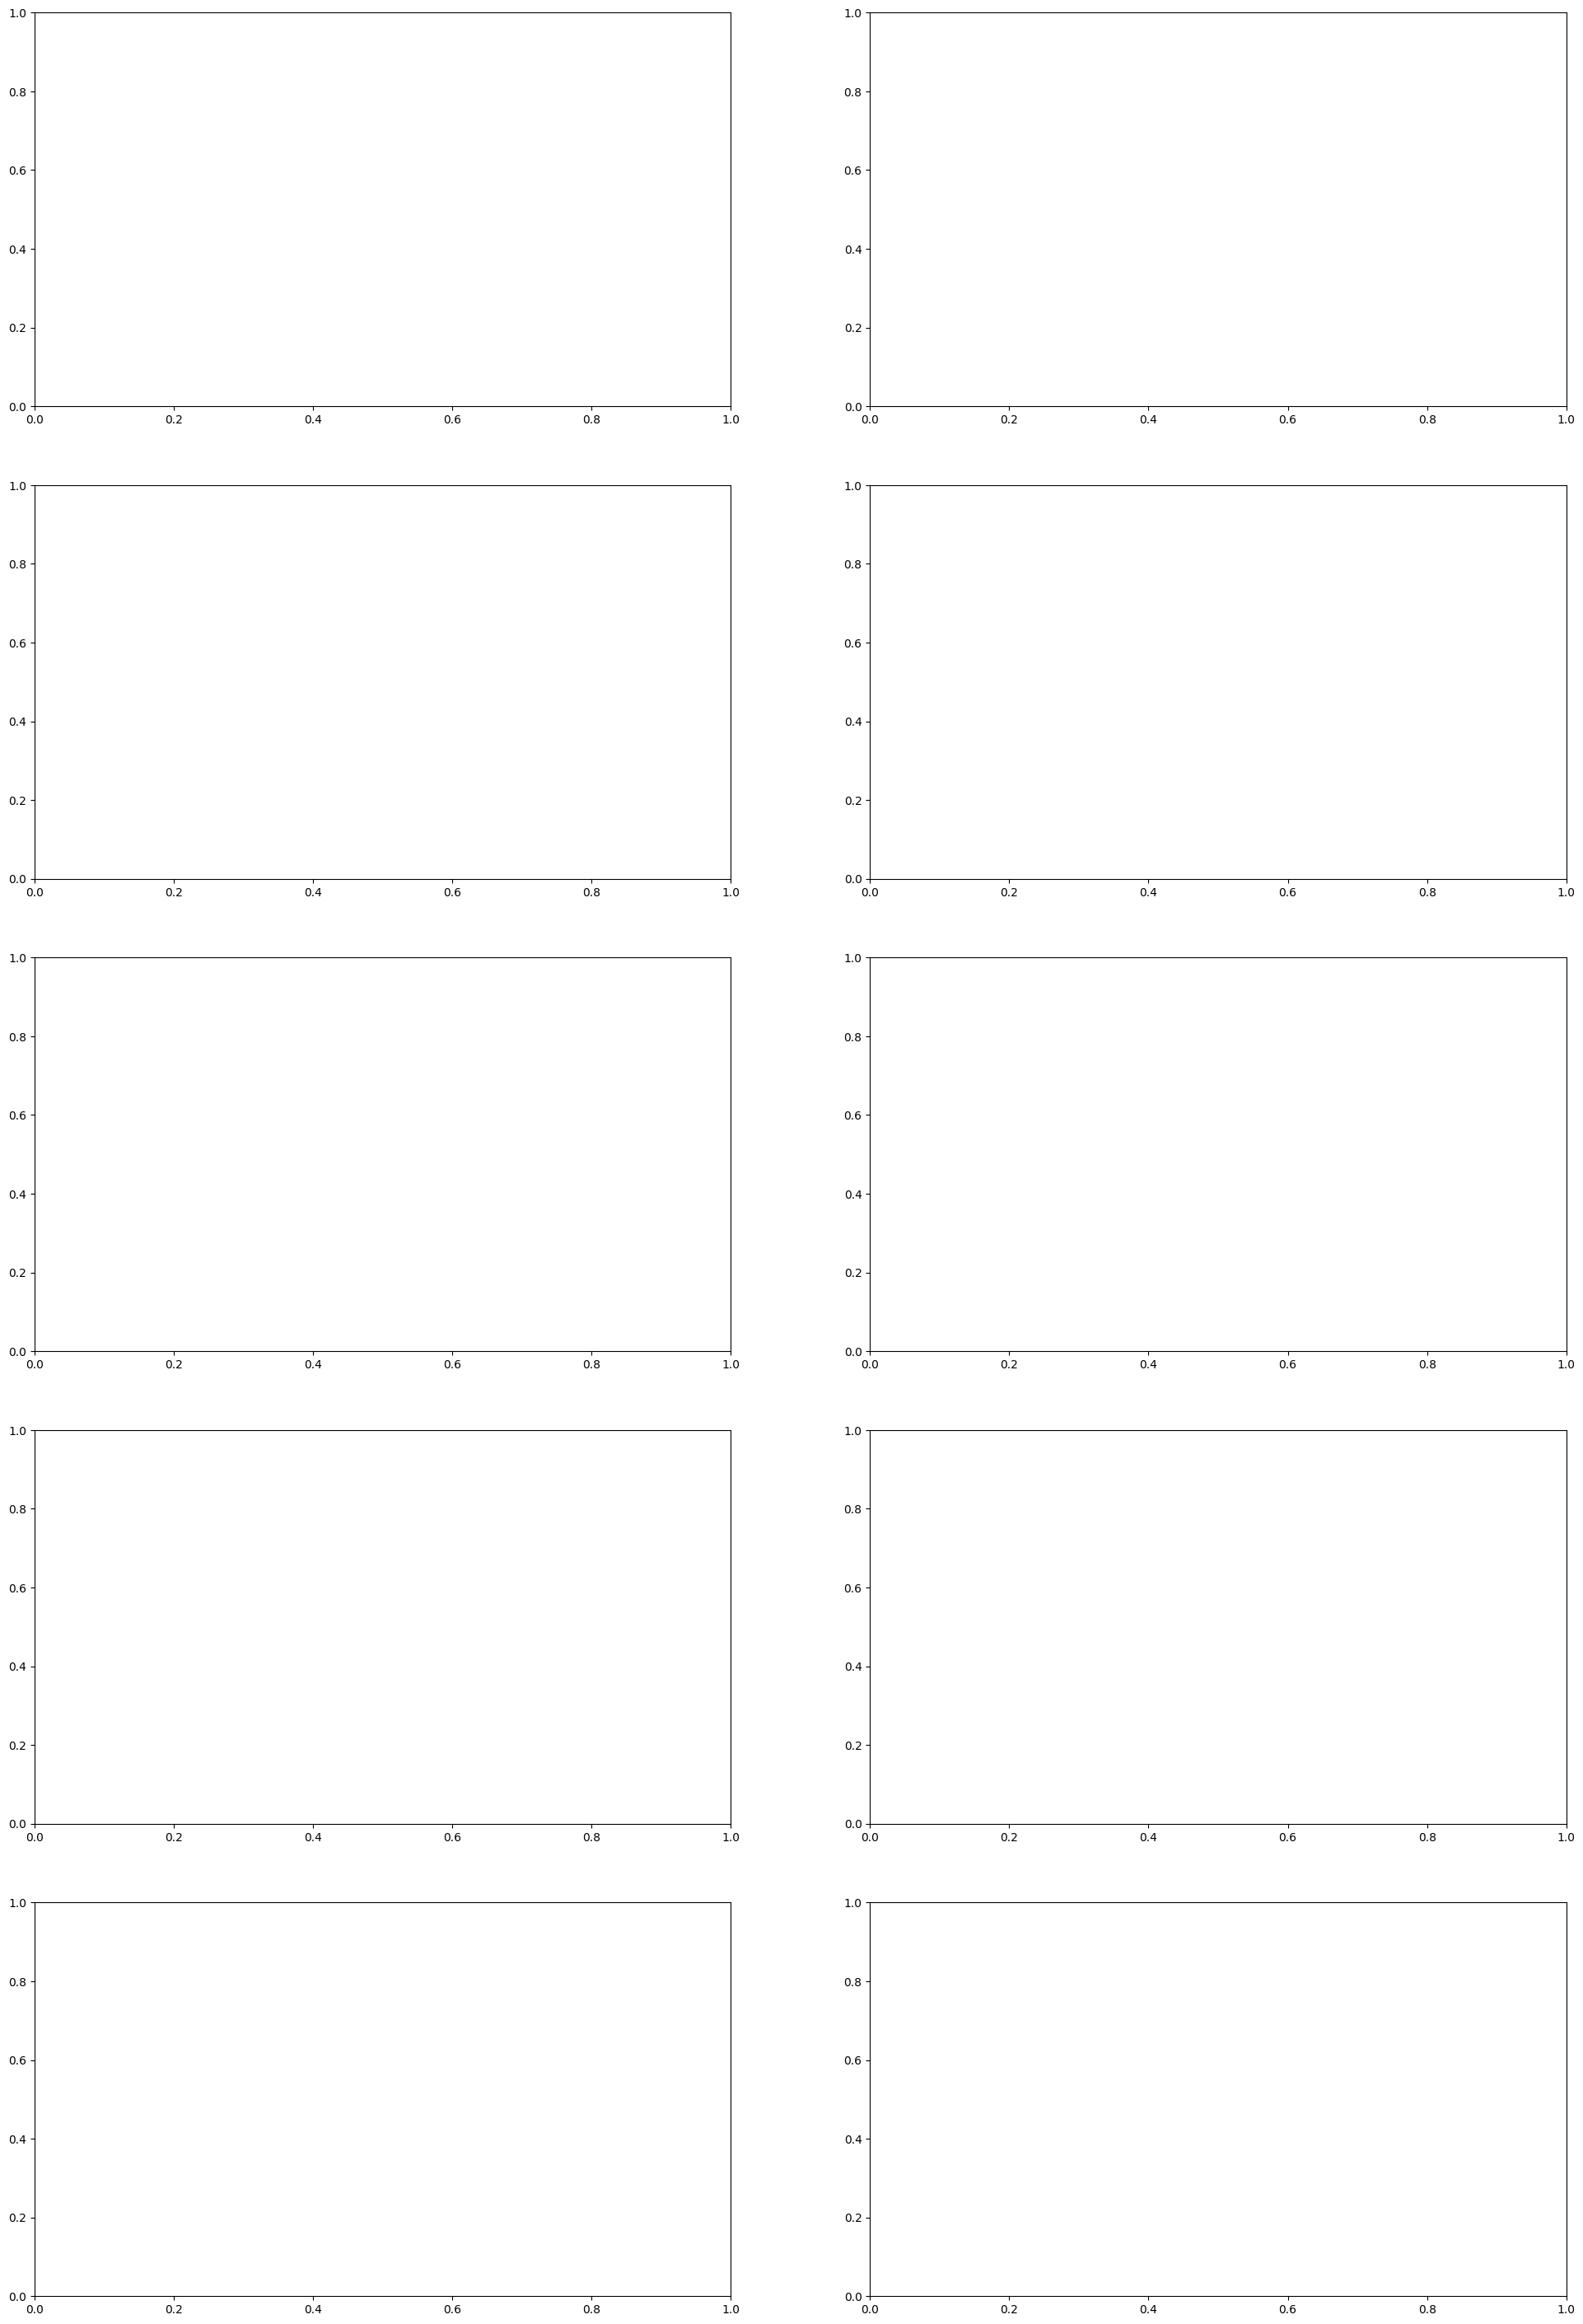

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Please DO NOT add any additional imports to this notebook
# Functionality using libraries other than those listed above will not be graded


def process_frames(video_cap: cv2.VideoCapture) -> np.ndarray:
    """
    Process video frames to clean and upscale them.
    
    Args:
    - video_cap (cv2.VideoCapture): A VideoCapture object to read frames from the video.

    Returns:
    - np.ndarray: A list of cleaned and upscaled frames.
    
    The process includes:
    - Reading in 10 frames.
    - Reducing noise and grain.
    - Mitigating motion blur, jitter, and blips.
    - Comparing neighboring frames for stabilization (image maps).
    - Upscaling the frames using interpolation.
    """
    
    frames = []

    # Step 1: Read in up to 10 frames from the video
    for _ in range(10):
        ret, frame = video_cap.read()
        if not ret:
            break
        frames.append(frame)
    
    cleaned_frames = []
    
    # Step 2: Process each frame
    for i, frame in enumerate(frames):
        # Step 2.1: Denoising - Reduce grain and noise without deteriorating image quality
        frame_cleaned = cv2.fastNlMeansDenoisingColored(frame, None, 10, 10, 7, 21)

        # Step 2.2: Motion blur reduction
        # Detect and reduce motion blur by applying a sharpening kernel if blur is detected
        frame_gray = cv2.cvtColor(frame_cleaned, cv2.COLOR_BGR2GRAY)
        blur = cv2.Laplacian(frame_gray, cv2.CV_64F).var()

        # Apply sharpening if blur is detected
        if blur < 100:  # Threshold value for detecting motion blur
            kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
            frame_cleaned = cv2.filter2D(frame_cleaned, -1, kernel)

        # Step 2.3: Compare neighboring frames (Image Maps) for stabilization
        if i > 0:
            prev_frame = cleaned_frames[-1]
            # Apply temporal smoothing (blending the current frame with the previous frame)
            frame_cleaned = cv2.addWeighted(frame_cleaned, 0.6, prev_frame, 0.4, 0)

        # Step 2.4: Upscale using cubic interpolation
        upscale_factor = 2  # Example factor for upscaling
        frame_upscaled = cv2.resize(frame_cleaned, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)

        # Append the processed frame to the cleaned frames list
        cleaned_frames.append(frame_upscaled)
    
    # Convert the list of frames to a numpy array
    return np.array(cleaned_frames)



# Please DO NOT change any of the code below. All modifications to this template should
# occur inside the **process_image** function

fig, axs = plt.subplots(5, 2)
fig.set_size_inches(24, 36)

video_cap = cv2.VideoCapture('./Zorro.mp4')
[video_cap.read() for _ in range(88)]
frames = process_frames(video_cap)

video_cap.release()

for i in range(5):
    for j in range(2):
        axs[i, j].imshow(frames[i*2 + j])

[cv2.imwrite(f"./frame_{i:02}.jpg", frame) for i, frame in enumerate(frames)]
plt.show()